In [58]:
#imports

import os
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

In [59]:
# Google Sheets Setup
SPREADSHEET_NAME = "price tag tableau"
GOOGLE_CREDENTIALS_FILE = "../leo-omega-ce3a42188817.json"
SCOPE = ['https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/spreadsheets']

# Authentification avec Google Sheets
creds = ServiceAccountCredentials.from_json_keyfile_name(GOOGLE_CREDENTIALS_FILE, SCOPE)
gc = gspread.authorize(creds)
worksheet = gc.open(SPREADSHEET_NAME).sheet1  # Première feuille
data = worksheet.get_all_records()

In [60]:
# Charger le design PNG depuis le même dossier
DESIGN_PATH = "design.png"
output_folder = "output_folder"

# Charger les polices
font_name = ImageFont.truetype("ArchivoBlack-Regular.ttf", 30)
font_ref = ImageFont.truetype("ArchivoBlack-Regular.ttf", 30)
font_price1 = ImageFont.truetype("ArchivoBlack-Regular.ttf", 30)
font_price2 = ImageFont.truetype("ArchivoBlack-Regular.ttf", 50)

# Taille A4 et divisions
A4_SIZE = (1414, 2000)
COLS, ROWS = 2, 4  # Diviser en 8 tags
TAG_WIDTH, TAG_HEIGHT = A4_SIZE[0] // COLS, A4_SIZE[1] // ROWS

# Position des textes dans le premier bloc (modifiable par l'utilisateur)
TEXT_POS = {
    "name": (50, 400),
    "ref": (50, 440),
    "new_price": (290, 260),
    "new_price_fmg": (290, 320),
    "last_price": (50, 270)
}

In [61]:
def format_price(price):
    """Ajoute des espaces dans le prix pour lisibilité (ex: 1234 -> '1 234 €')."""
    return f"{price:,.0f}".replace(",", " ")

In [62]:
def draw_price_tag(draw, tag_x, tag_y, item):
    """Dessiner un price tag dans une section spécifique de l'image."""
    x_offset, y_offset = tag_x * TAG_WIDTH, tag_y * TAG_HEIGHT
    
    name = f"Article: {item["Name"][:20]}"
    ref = f"Ref: {str(item["Ref"])}"
    new_price = f"{format_price(item['New Price'])} Ar"
    new_price_fmg = f"{format_price(item['New Price Fmg'])} Fmg"
    last_price = f"{format_price(item['Last Price'])} Ar"
    
    draw.text((TEXT_POS["name"][0] + x_offset, TEXT_POS["name"][1] + y_offset), name, font=font_name, fill="black")
    draw.text((TEXT_POS["ref"][0] + x_offset, TEXT_POS["ref"][1] + y_offset), ref, font=font_ref, fill="black")
    draw.text((TEXT_POS["new_price"][0] + x_offset, TEXT_POS["new_price"][1] + y_offset), new_price, font=font_price2, fill="#004aad")
    draw.text((TEXT_POS["new_price_fmg"][0] + x_offset, TEXT_POS["new_price_fmg"][1] + y_offset), new_price_fmg, font=font_price1, fill="black")
    draw.text((TEXT_POS["last_price"][0] + x_offset, TEXT_POS["last_price"][1] + y_offset), last_price, font=font_price1, fill="black")

In [63]:
def draw_grid(draw):
    """Dessiner les lignes de séparation des tags."""
    # Lignes horizontales
    for row in range(1, ROWS):
        y = row * TAG_HEIGHT
        draw.line([(0, y), (A4_SIZE[0], y)], fill="black", width=1)

    # Lignes verticales
    for col in range(1, COLS):
        x = col * TAG_WIDTH
        draw.line([(x, 0), (x, A4_SIZE[1])], fill="black", width=1)

Image sauvegardée : output_folder/price_tags_1.png


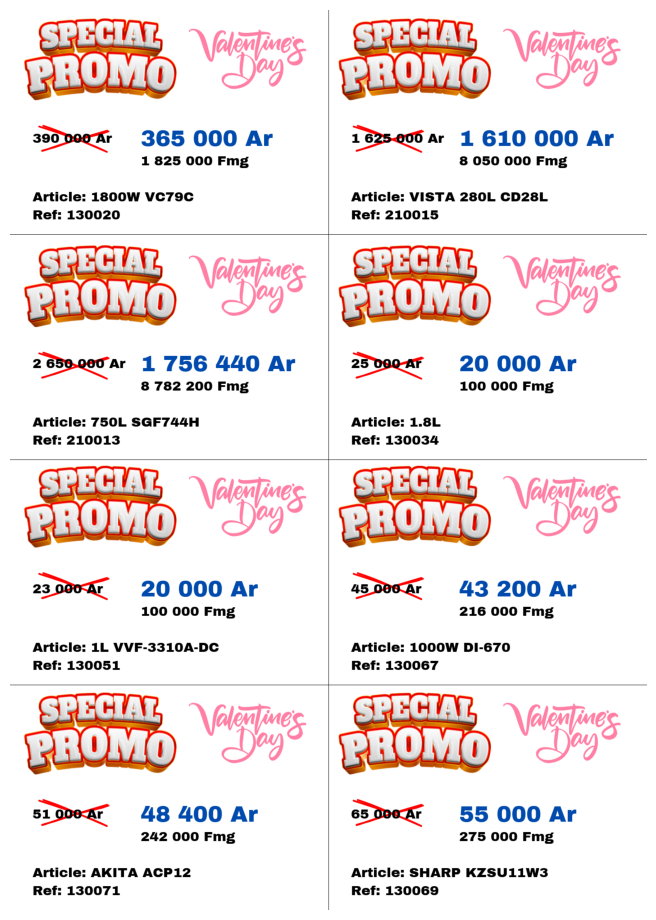

Image sauvegardée : output_folder/price_tags_2.png


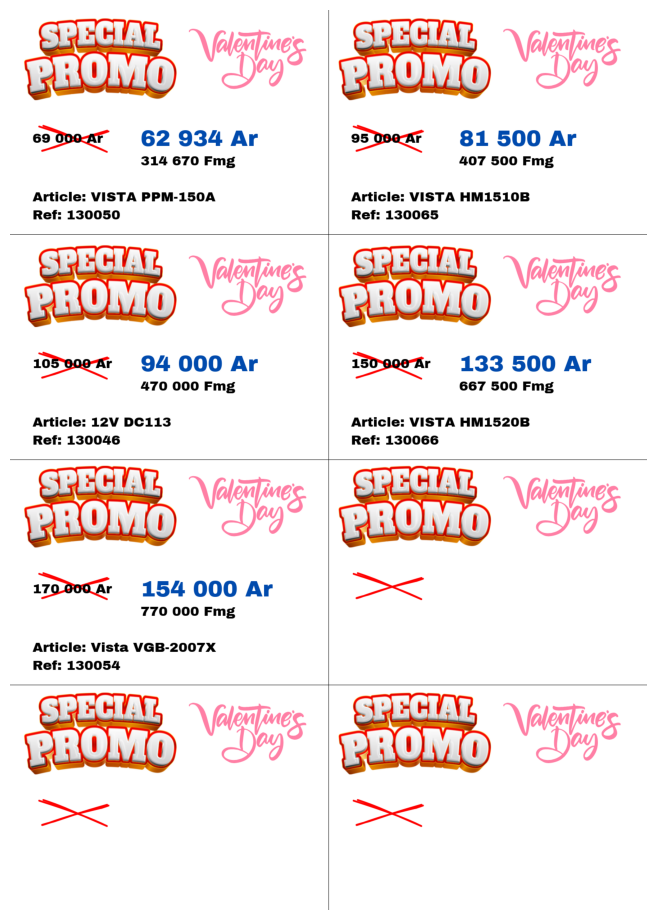

In [64]:
# Création des pages avec une boucle while
i = 0
page_number = 1

while i < len(data):
    # Nouvelle page
    current_page = Image.open(DESIGN_PATH).convert("RGBA")
    draw = ImageDraw.Draw(current_page)

    # Dessiner la grille de séparation
    draw_grid(draw)

    # Remplir la page avec 8 produits maximum
    for row in range(ROWS):
        for col in range(COLS):
            if i < len(data):
                draw_price_tag(draw, col, row, data[i])
                i += 1
            else:
                break  # Si plus de produits à traiter, on arrête ici
    
    # Sauvegarde de la page
    output_path = os.path.join(output_folder, f"price_tags_{page_number}.png")
    current_page.save(output_path)
    print(f"Image sauvegardée : {output_path}")

    # Affichage de la page
    plt.figure(figsize=(8.27, 11.69))
    plt.imshow(np.array(current_page))
    plt.axis("off")
    plt.show()

    page_number += 1